In [1]:
import time
import pickle
import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm

// codice che usavo prima (importavo tutto il codice pesante, ora importo solo il corpus finale!!)

time1 = time.time()
import TextImport
time2 = time.time()
print((time2-time1))

Primo Import iniziato alle 13:21 , finito alle 13:33 (800 secondi)

Secondo import 580 secondi

Terzo Import 581 secondi

La cosa strana è che runnando TextImport su visualStudio ci mette 250 secondi! (ovvero runnare è più
veloce che importare!?)

# Rappresentazione del corpus usando i word embeddings:


In [2]:
with open('corpus_filtrato15_11.pkl', 'rb') as file:
    # Carica i dati dal file
    corpus_filtrato = pickle.load(file) # corpus filtrato è il corpus senza le parole inutili

Corpus_filtrato è stato prodotto dal file "TextImportOriginale" nella cartella "word embeddings", vado lì se voglio modificare qualcosa!

In [7]:
with open("my_vecs_preProcessingSenzaParoleInutili.p", "rb") as file:
    word2Vec_model = pickle.load(file)

Vedo Word2VecDatiIMPORT nella cartella WordEmbedding per avere un'idea di come usare gli embedding e di come sono stati fatti.

In seguito spiego la corrispondenza univoca fra i vettori numerici (embeddings) delle parole del modello e le parole presenti in Vocabolario preso da "textImport"

In [10]:
word_names = word2Vec_model.wv.index_to_key # word names è la stringa di parola corrispondente all'embedding numerico
# (Traduzione Embedding -> stringa)
word_vectors = [word2Vec_model.wv[word] for word in word_names]
# word_vectors è l'embedding relativo alle parole di word_names



Osservazione:

In [7]:
# ParoleMancanti = [parola for parola in word_names if parola not in TextImport.Vocabolario]
#print(len(word_names))
#print(len(TextImport.ListaParoleInutili))
#print(len(word_names)-len(TextImport.ListaParoleInutili))
#len(TextImport.Vocabolario)

# Risultato importantissimo, prima mi veniva che word_names (ovvero il vettore delle parole sputate dal modello di gensim) e 
# il mio Vocabolario avessero lunghezza lievemente diversa. Questo era perchè in precedenza, sbagliando avevo allenato il modello 
# senza togliere le parole inutili. Ora invece tutto torna!

Ora traduco il corpus (lista di liste di parole ovvero lista di documenti) traducendo ogni parola in embedding!

In [11]:
corpus_filtrato_embedding = []
for doc in corpus_filtrato:
    doc_embedding = []
    for parola in doc:
        doc_embedding.append(word2Vec_model.wv[parola])
    corpus_filtrato_embedding.append(doc_embedding)
    

In [9]:
#corpus_filtrato_embedding[0][0]
# ho fatto diverse prove e sembra proprio che tutto il procedimento di traduzione sia andato a buon fine!

Corpus_filtrato_embedding è il corpus formato solo dalle parole utili, dove ogni parola è un vettore di dim 10 (embedding)

# Costruzione grafo:


Iniziamo con il modello più semplice possibile, ovvero i collegamenti di una parola sono solo con la precedente e con la successiva

Consideriamo il primo documento, da trasformare in un grafo, da questo tutti gli altri documenti verranno modificati con lo stesso procedimento, l'unica differenza è la lunghezza del documento ma non è un problema.

In [10]:
Doc0 = corpus_filtrato_embedding[0]
Doc0 = np.array(Doc0) # meglio averceli in numpy per fare le operazionui!

In [11]:
import numpy as np

In [12]:
'''
def CreaRigaAdj(k,dim): #funzione che crea una lista con 1 solo nella posizione prima e dopo k
    retList = [0]*dim
    if (k == 0): # devo fare il caso k ==0 altrimenti k-1 = -1 mi dà l'elemento in fondo alla lista!
        retList[1] = 1
    elif (k == dim-1):
        retList[k-1] = 1
    else:
        retList[k-1] = 1
        retList[k+1] = 1
    return retList
    
A0 = []
for i in range(len(Doc0)):
    A0.append(CreaRigaAdj(i,len(Doc0)))
'''

# OSS. questo metodo era meno smart e non restituiva una matrice di tipo numpy!

"\ndef CreaRigaAdj(k,dim): #funzione che crea una lista con 1 solo nella posizione prima e dopo k\n    retList = [0]*dim\n    if (k == 0): # devo fare il caso k ==0 altrimenti k-1 = -1 mi dà l'elemento in fondo alla lista!\n        retList[1] = 1\n    elif (k == dim-1):\n        retList[k-1] = 1\n    else:\n        retList[k-1] = 1\n        retList[k+1] = 1\n    return retList\n    \nA0 = []\nfor i in range(len(Doc0)):\n    A0.append(CreaRigaAdj(i,len(Doc0)))\n"

In [125]:
A0 = np.zeros(shape = [len(Doc0),len(Doc0)], dtype = int)
for i in range(len(Doc0)):
    if (i == 0): # devo fare il caso k ==0 altrimenti k-1 = -1 mi dà l'elemento in fondo alla lista!
        A0[i][1] = 1
    elif (i == len(Doc0)-1):
        A0[i][len(Doc0)-2] = 1
    else:
        A0[i][i-1] = 1
        A0[i][i+1] = 1 


Per fare un paragone coi papers, A0 è la matrice di adiacenza A (NxN) e doc0 è la matrice delle features H (NxD) (che alcun chiamano X). Cerchiamo ora di ricondurci alla forma di GCN (KIPF and WELLING 2017)

H(l+1) = σ
(
D˜ − 1/
2 A˜D˜ − 1/
2 H(l)W(l)
)

In [14]:
Atilde = A0
for i in range(len(A0)):
    Atilde[i][i]=1

In [15]:
Dtilde = np.zeros(shape = (len(A0),len(A0)), dtype = int)

In [16]:
Dtilde = np.zeros(shape = (len(A0),len(A0)), dtype = int)
for i in range(len(A0)):
    Dtilde[i][i] = sum(Atilde[i])

In [17]:
'''
inverse_Dtilde = np.linalg.inv(Dtilde)
eigenvalues, eigenvectors = np.linalg.eig(inverse_Dtilde)
eigenvalues_Diag_Matsquareroot = np.diag(np.sqrt(eigenvalues))
Dtildeinvsquaredroot= eigenvectors@eigenvalues_Diag_Mat@np.linalg.inv(eigenvectors)
Dtildeinvsquaredroot
'''
# questo codice è la matematica dietro alla radice quadrata dell'inversa, dopo lo faccio in maniera più veloce con scipy

'\ninverse_Dtilde = np.linalg.inv(Dtilde)\neigenvalues, eigenvectors = np.linalg.eig(inverse_Dtilde)\neigenvalues_Diag_Matsquareroot = np.diag(np.sqrt(eigenvalues))\nDtildeinvsquaredroot= eigenvectors@eigenvalues_Diag_Mat@np.linalg.inv(eigenvectors)\nDtildeinvsquaredroot\n'

In [18]:
import scipy
invDtilde =  np.linalg.inv(Dtilde)
invDtildesquareroot=scipy.linalg.sqrtm(invDtilde)
#invDtildesquareroot.shape

In [19]:
Doc0.shape[1]

10

In [20]:
'''
def sigmoid (matrix):# performed row wise
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            matrix[i][j] = 1/(1+np.exp(-matrix[i][j]))
    return matrix
'''
# era il mio codice originario, in realtà questo sotto fa la stessa cosa perchè python legge la matrice un elemento per volta
# quindi facendo così si semplifica il codice (ho provato anche a vedere il tempo di entrambi i metodi) e il secondo ci mette
# mediamente la metà

def sigmoid (matrix):# performed row wise
    
    return 1/(1+np.exp(-matrix))


In [21]:
np.random.seed(42)
H_presente = Doc0
W_presente = np.random.rand(Doc0.shape[1],Doc0.shape[1]) # Random component quindi metto random seed in alto x riproducibilità
H_successivo = sigmoid(invDtildesquareroot@Atilde@invDtildesquareroot@H_presente@W_presente)
print(H_successivo)
H_successivo.shape

[[0.75808705 0.36138419 0.57640122 ... 0.44087793 0.47635533 0.5338241 ]
 [0.79567391 0.3612015  0.58983532 ... 0.48830949 0.55423853 0.55150342]
 [0.81000526 0.44578849 0.64525686 ... 0.51567642 0.55950497 0.55634878]
 ...
 [0.70364217 0.31804943 0.4794203  ... 0.45514986 0.56804916 0.54931815]
 [0.77079647 0.33606906 0.53829949 ... 0.53441076 0.66527386 0.58944469]
 [0.74688682 0.40693133 0.55957176 ... 0.57475352 0.69495125 0.55788586]]


(499, 10)

I passi successivi sono principalmente 2:

1) Ora ho costruito il grafo per Doc0, devo fare la stessa cosa per gli altri 10213 documenti

2) Devo trovare il modo di allenare il modello, ovvero aggiornare i pesi di W_presente con una loss function (vedo paper clustering)

# Provo GCN in maniera supervised con labels fittizzi

In [22]:
# Come idea dei label per i nodi metto che la classificazione sia fatta in parole brevi, medie lunghe:

In [23]:
#corpus_filtrato

In [24]:
sum = 0
for word in corpus_filtrato[0]:
    sum += len(word)
mean = sum/len(corpus_filtrato[0])
mean

6.218436873747495

Parole più corte di 5 lettere sono brevi (0), parole fra 5 e 9  sono medie (1), parole più di 9 sono lunghe (2)

In [25]:
LABELS = np.zeros(shape = (len(corpus_filtrato[0]),3), dtype = int)
for i,word in enumerate(corpus_filtrato[0]):
    if len(word)<5:
        LABELS[i][0]=1
        
    elif len(word)>9:
        LABELS[i][2]=1
    else:
        LABELS[i][1]=1
    #print(len(word))
    

In [50]:
#np.set_printoptions(threshold=np.inf) per printare tutta la matrice e non solo alcune righe
print(LABELS)

[[0 1 0]
 [1 0 0]
 [0 1 0]
 ...
 [0 0 1]
 [0 0 1]
 [0 1 0]]


Mi baso ora su pytorch geometric, i quali richiedono il grafo in formato  "torch_geometric.data.Data" per i modelli successivi, faccio questo per prima cosa!
# Tutorial 1

In [27]:
import torch
from torch_geometric.data import Data

In [30]:
A0

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 1, 1]])

Devo trasformare A0 in una lista di adiacenza come vuole pytorch geometric!:

In [34]:
adj_list = []
for i in range(len(A0)):
    for j in range(len(A0)):
        if (A0[i][j]==1 and j!=i):
            temp_list = [i,j]
            adj_list.append(temp_list)
        
    

In [41]:
Doc0

array([[-0.11068563, -0.5326252 ,  0.86516297, ..., -0.06655114,
        -0.17851014,  0.21890694],
       [-0.51522696, -1.0387008 ,  1.1703496 , ..., -0.3740427 ,
        -0.5833328 , -0.22025317],
       [-0.6063753 ,  0.3164312 ,  1.7273585 , ...,  0.6947744 ,
        -0.9461107 , -0.25950187],
       ...,
       [-0.45306423, -0.6907194 ,  0.6036256 , ..., -0.3809749 ,
         0.02652384, -0.36844888],
       [-0.7124144 , -0.49716508,  1.0456138 , ..., -0.13115153,
        -0.5543687 ,  0.16673848],
       [-0.3750048 ,  0.30667436,  1.9497802 , ...,  0.2292165 ,
         0.03109064,  0.2720961 ]], dtype=float32)

Trasformo anche y come lista di adiacenza (e non matrice(LABELS))

In [98]:
y_list = []
for i,lista in enumerate(LABELS):
    if(lista[0]==1):
        y_list.append(0)
    elif(lista[1]==1):
        y_list.append(1)
    elif(lista[2]==1):
        y_list.append(2)
#y_list
y_list = torch.tensor(y_list)

In [36]:
#adj_list # ok torna


In [115]:
import random

# Numero totale di affermazioni
total_affirmations = 499

# Percentuale di affermazioni vere
percentage_true = 10

# Calcola il numero di affermazioni vere
num_true = int(total_affirmations * percentage_true / 100)

# Crea la lista di affermazioni
affirmations = [True] * num_true + [False] * (total_affirmations - num_true)

# Mescola la lista in modo casuale
random.shuffle(affirmations)

# Stampa la lista
#for index, statement in enumerate(affirmations, start=1):
    #print(f"{index}. {statement}")

In [77]:
import tensorflow as tf

In [109]:
MASK = torch.tensor(affirmations)
#MASK

In [99]:
edge_index = torch.tensor(adj_list, dtype=torch.long)
x = torch.tensor(Doc0, dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(),y = y_list, train_mask = MASK)
data

Data(x=[499, 10], edge_index=[2, 996], y=[499], train_mask=[499])

NB: TUTTI GLI ELEMENTI DI "Data" devono essere nella forma torch.tensor, quindi se li creo come liste poi devo modificarli!

 Il codice seguende è preso dal tutorial pytorch geometric numero 1 di colab (sito ufficiale pytorch geometric)

In [100]:
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

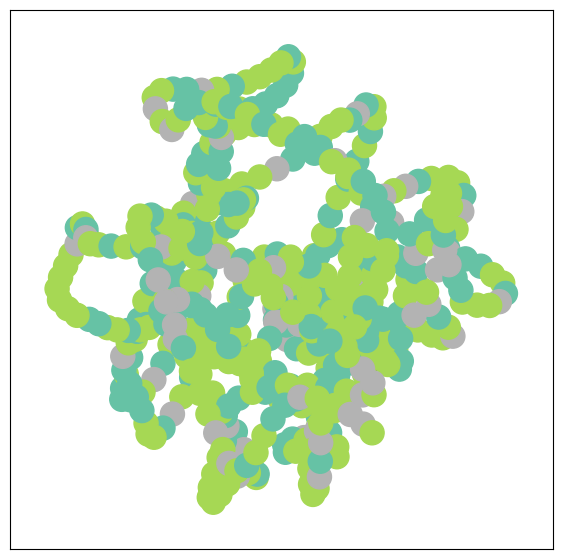

In [101]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [102]:
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 499
Number of edges: 996
Average node degree: 2.00
Number of training nodes: 49
Training node label rate: 0.10
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [103]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(Doc0.shape[1], 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, 3)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(10, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=3, bias=True)
)


Embedding shape: [499, 2]


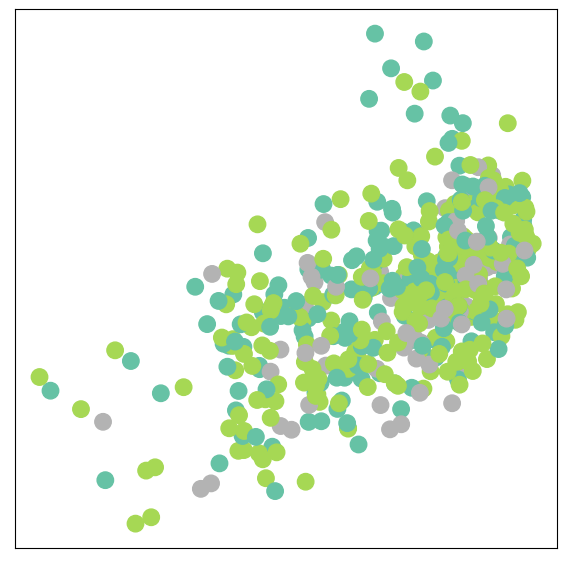

In [104]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

Questo è l'embedding prima ancora di fare GCN!

# Tutorial 2
Codice sulla base di colab tutorial 2 (Pytorch Geometric)

IL tutorial 1 è data visualization e come creare il modello, nel tutorial 2 lo trainiamo!

In [105]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(Doc0.shape[1], hidden_channels)
        self.lin2 = Linear(hidden_channels, 3)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=10, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=3, bias=True)
)


In [106]:
type(data.train_mask)

torch.Tensor

In [117]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.0480
Epoch: 002, Loss: 1.0274
Epoch: 003, Loss: 1.0089
Epoch: 004, Loss: 0.9857
Epoch: 005, Loss: 0.9935
Epoch: 006, Loss: 0.9316
Epoch: 007, Loss: 0.9244
Epoch: 008, Loss: 0.9628
Epoch: 009, Loss: 0.9295
Epoch: 010, Loss: 0.9491
Epoch: 011, Loss: 0.9715
Epoch: 012, Loss: 0.9339
Epoch: 013, Loss: 0.8767
Epoch: 014, Loss: 0.9553
Epoch: 015, Loss: 0.9585
Epoch: 016, Loss: 0.8526
Epoch: 017, Loss: 0.9956
Epoch: 018, Loss: 0.9466
Epoch: 019, Loss: 0.8582
Epoch: 020, Loss: 0.8867
Epoch: 021, Loss: 0.8905
Epoch: 022, Loss: 0.8689
Epoch: 023, Loss: 0.9136
Epoch: 024, Loss: 0.9086
Epoch: 025, Loss: 0.8452
Epoch: 026, Loss: 0.8717
Epoch: 027, Loss: 0.8540
Epoch: 028, Loss: 0.8440
Epoch: 029, Loss: 0.8352
Epoch: 030, Loss: 0.8028
Epoch: 031, Loss: 0.8006
Epoch: 032, Loss: 0.8725
Epoch: 033, Loss: 0.8097
Epoch: 034, Loss: 0.8272
Epoch: 035, Loss: 0.7625
Epoch: 036, Loss: 0.7735
Epoch: 037, Loss: 0.7778
Epoch: 038, Loss: 0.8045
Epoch: 039, Loss: 0.8008
Epoch: 040, Loss: 0.7961


<IPython.core.display.Javascript object>

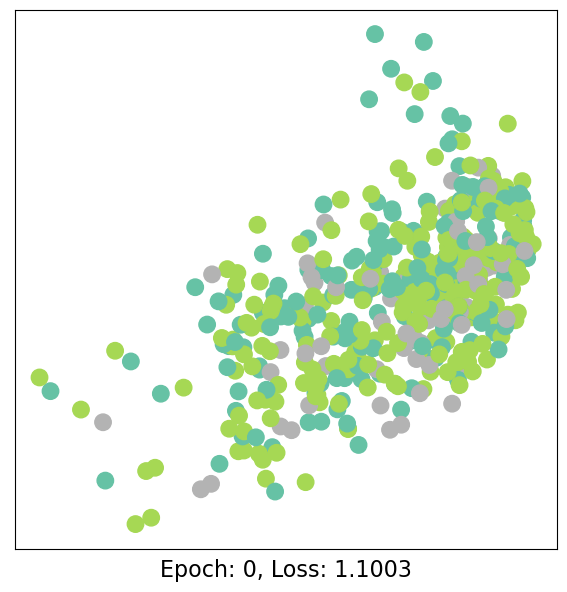

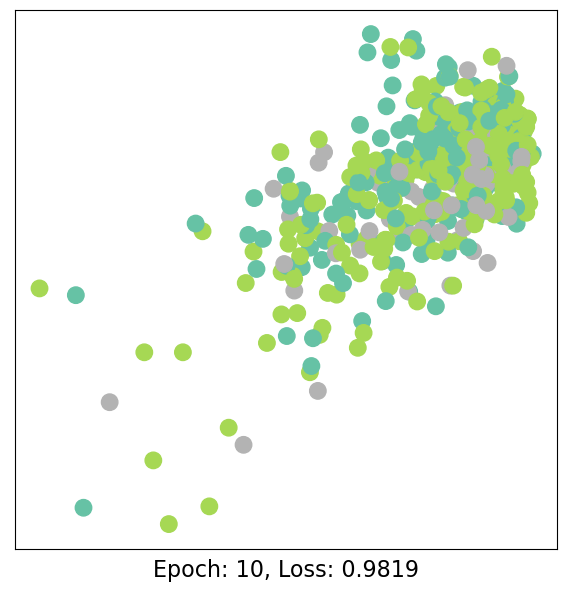

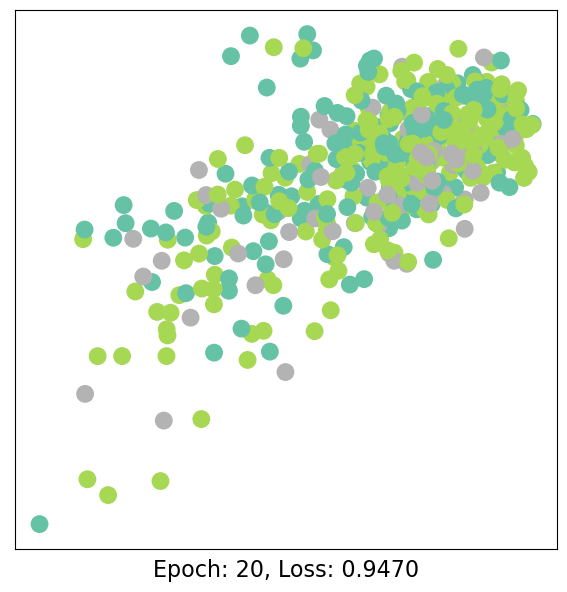

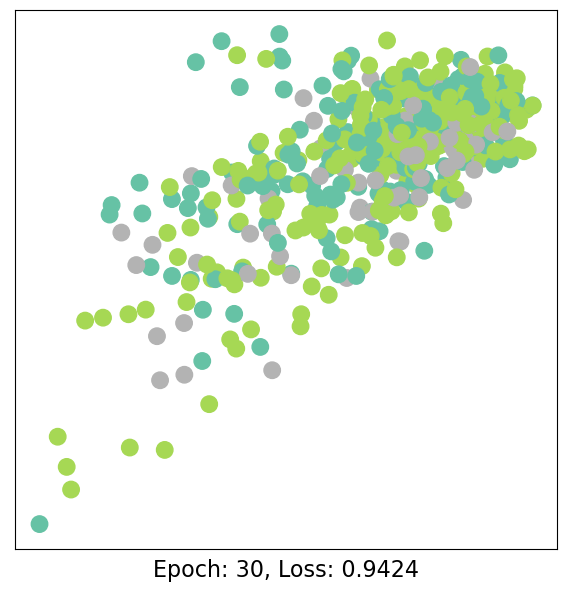

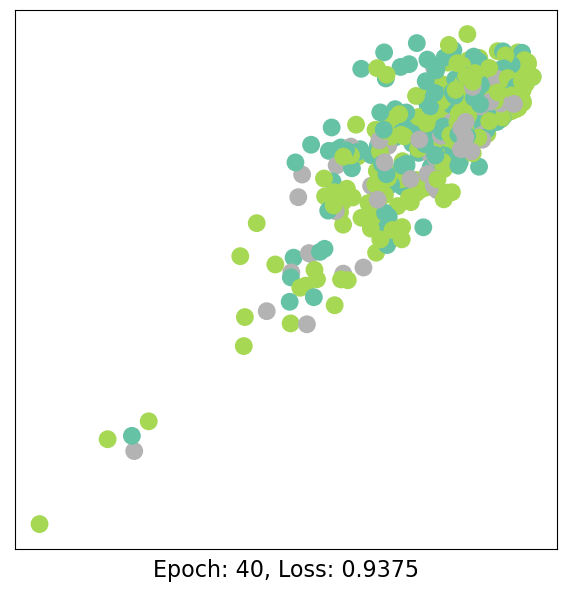

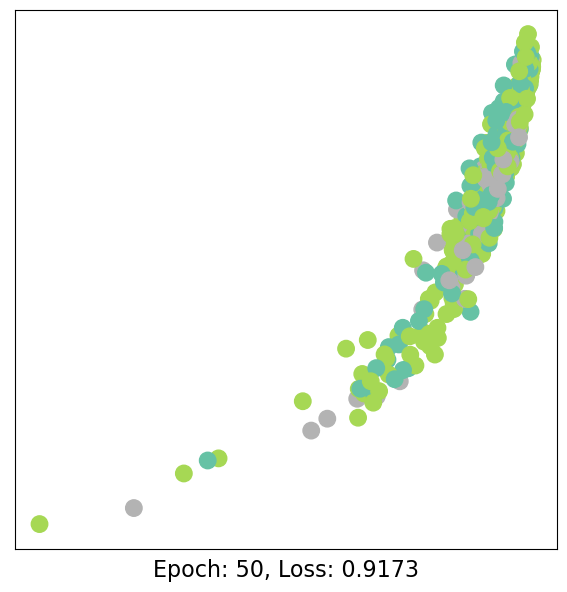

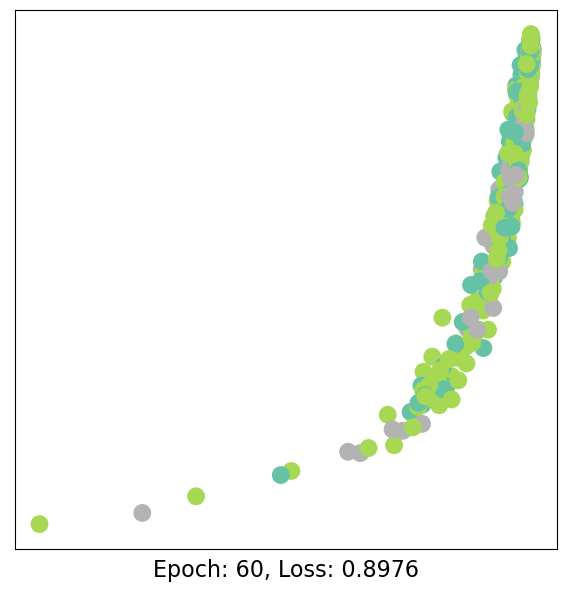

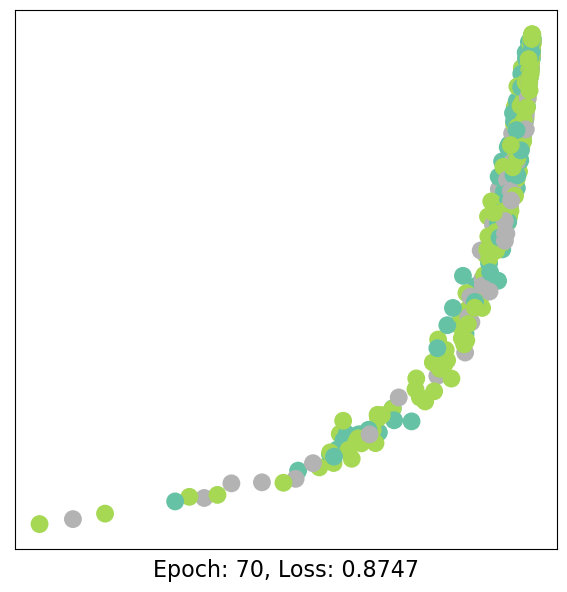

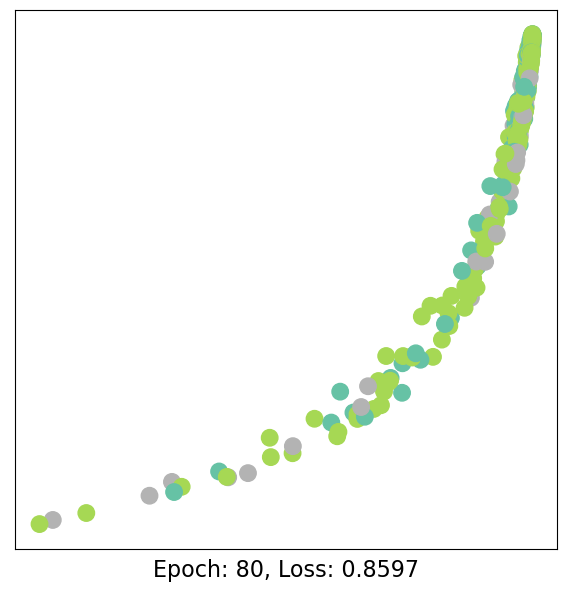

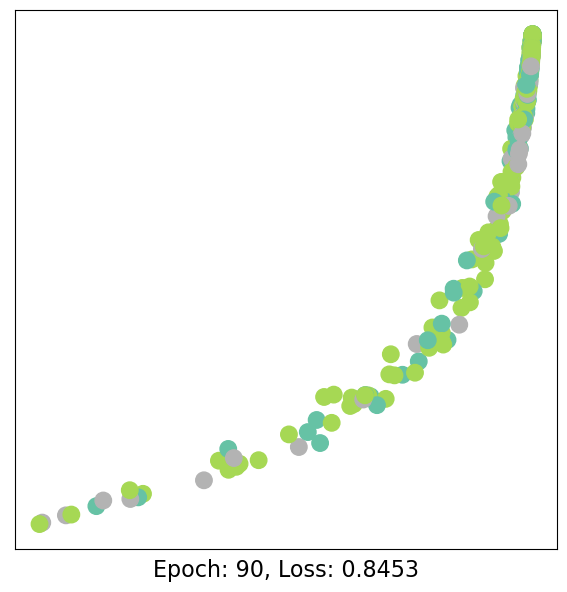

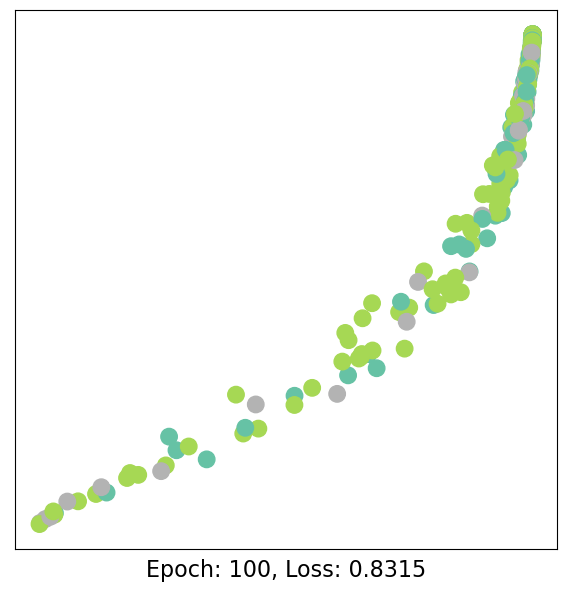

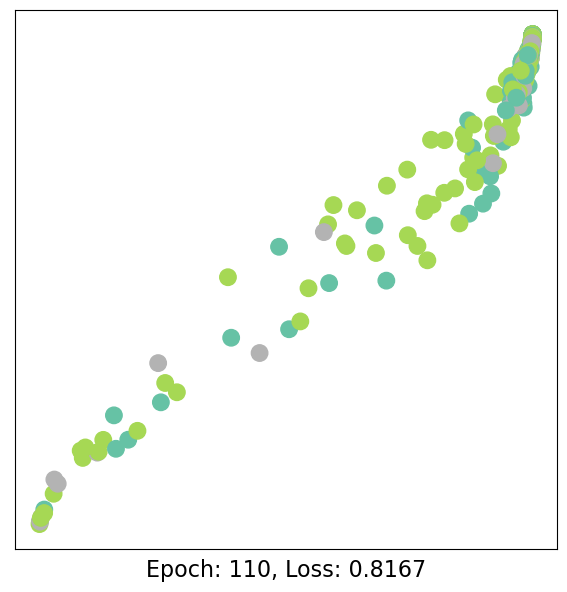

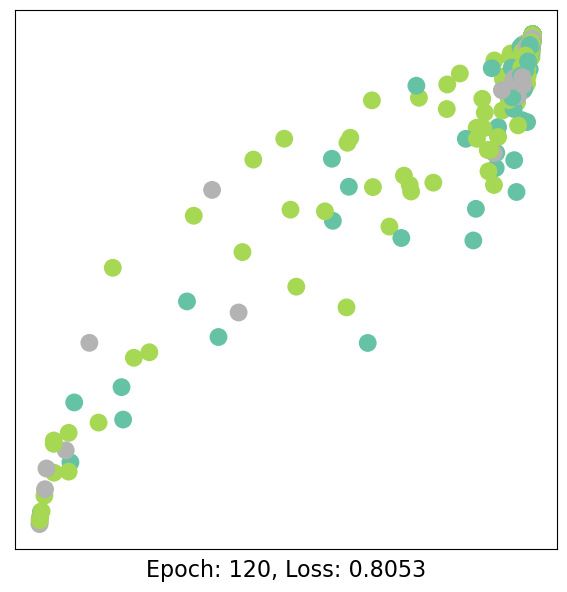

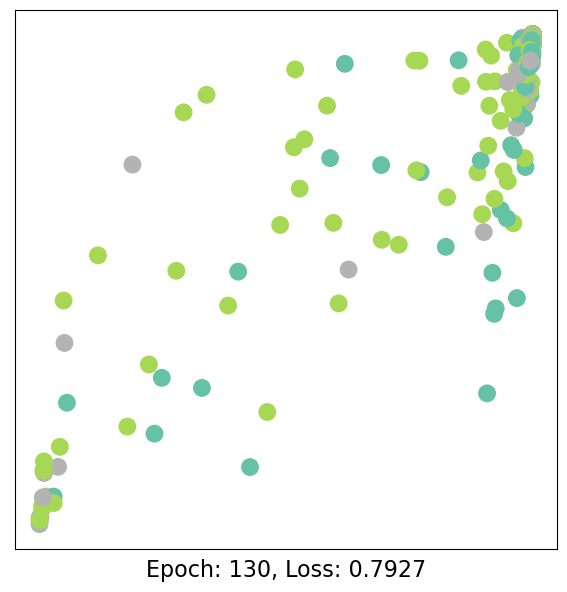

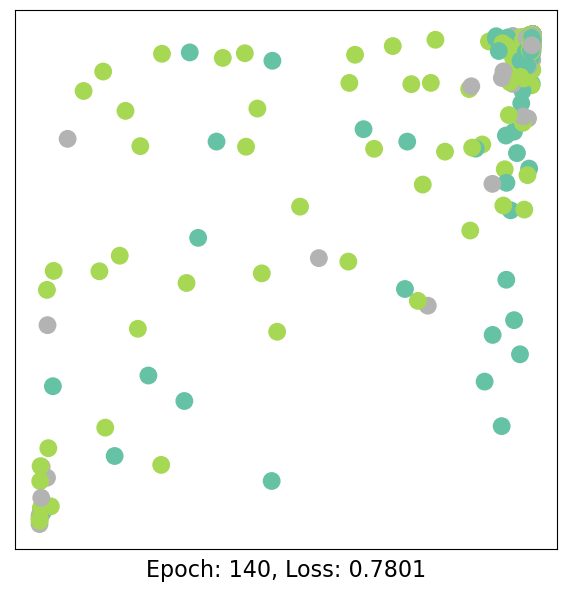

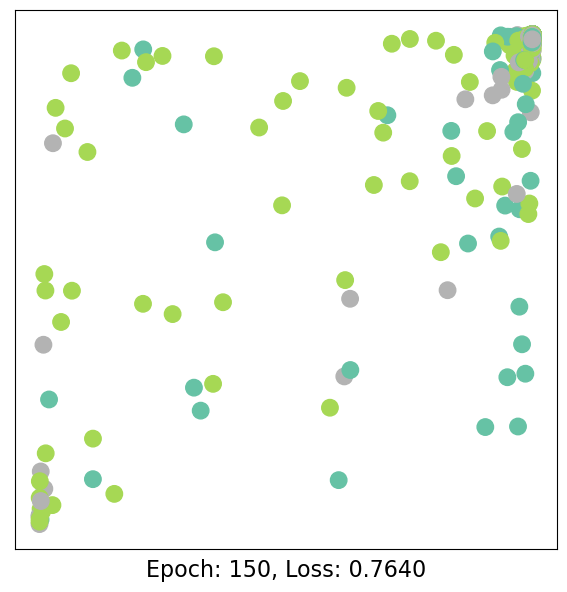

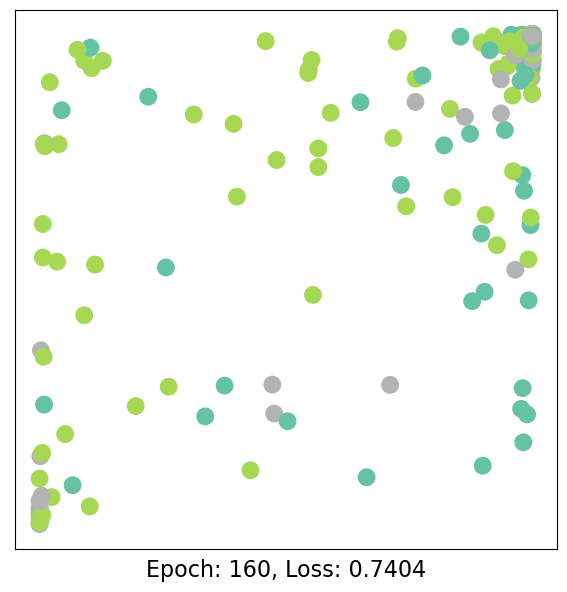

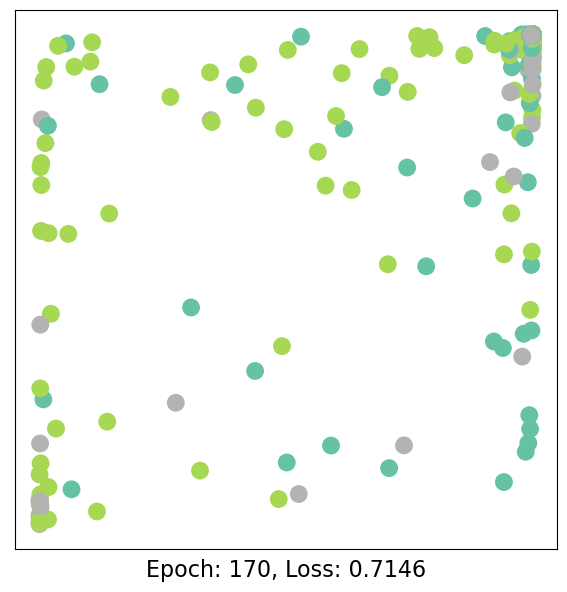

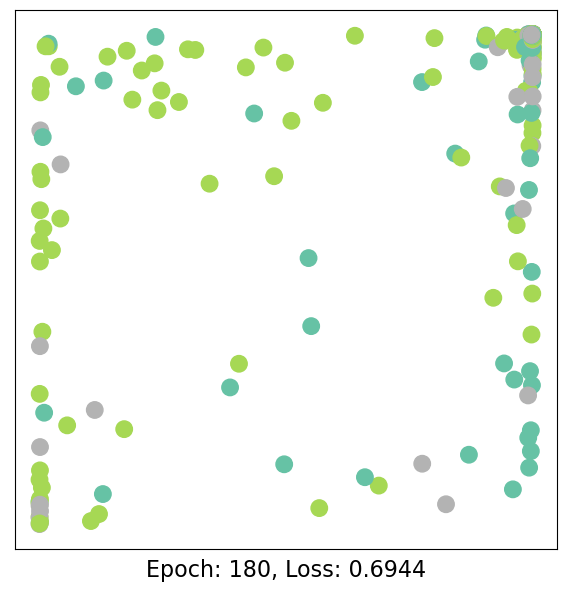

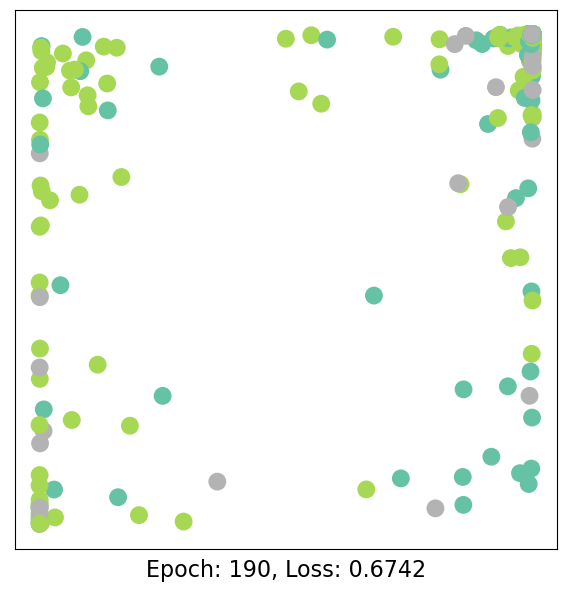

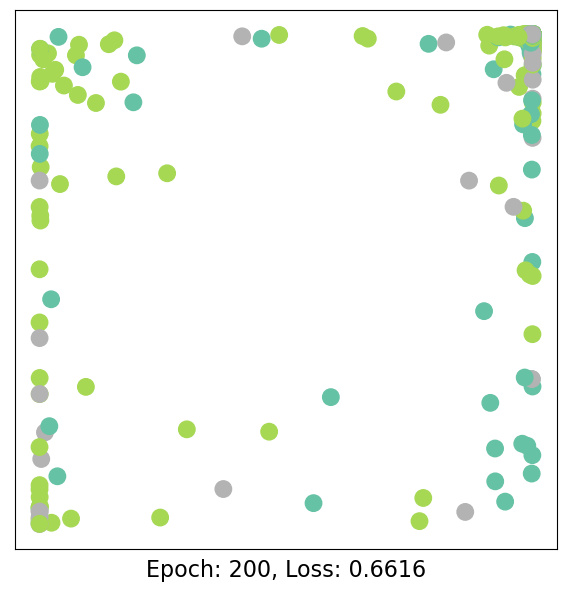

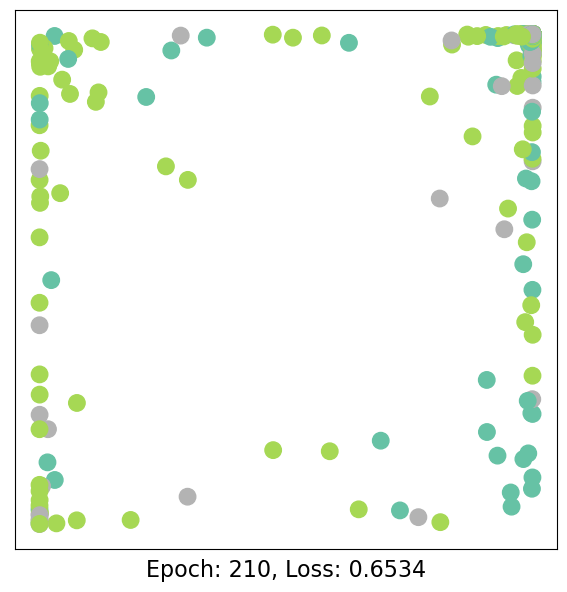

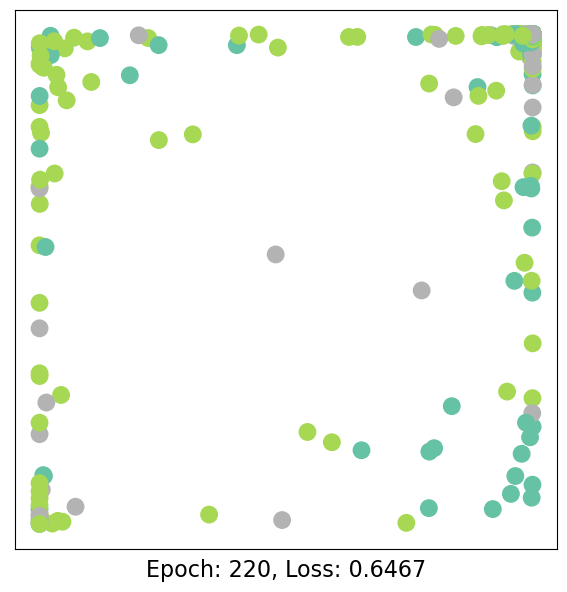

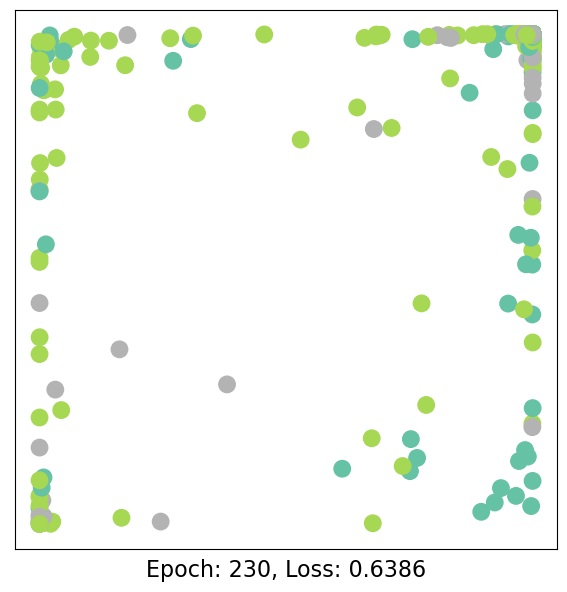

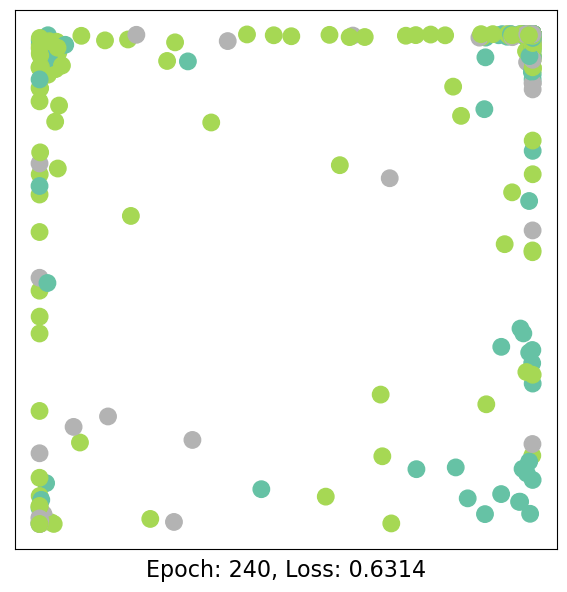

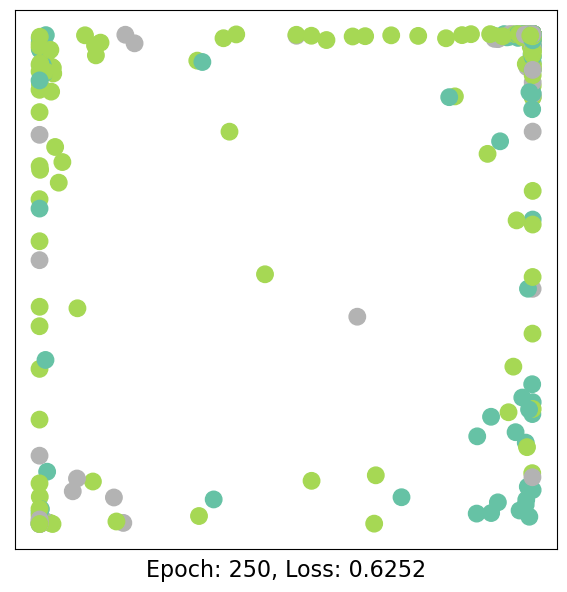

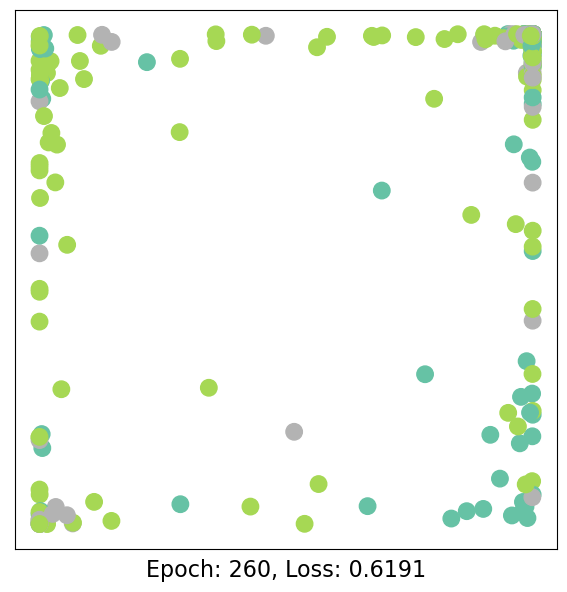

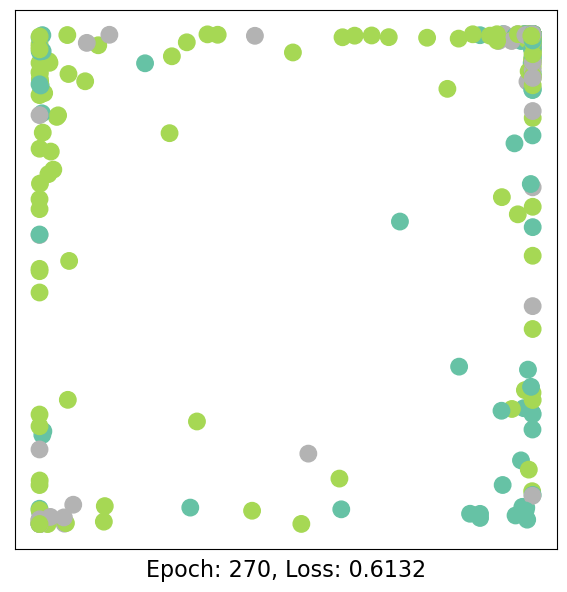

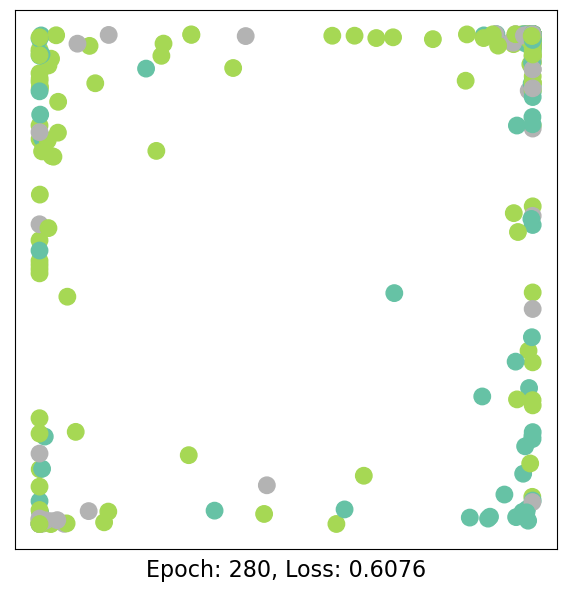

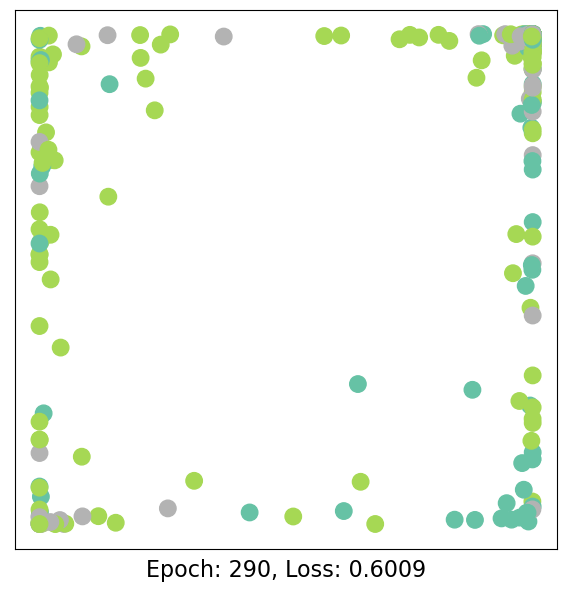

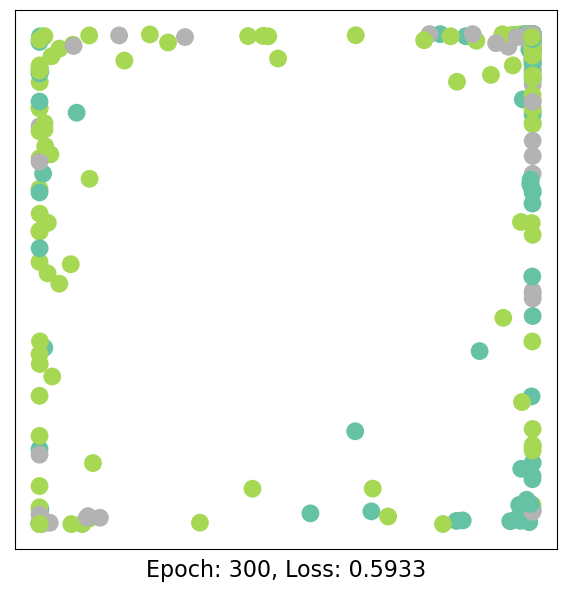

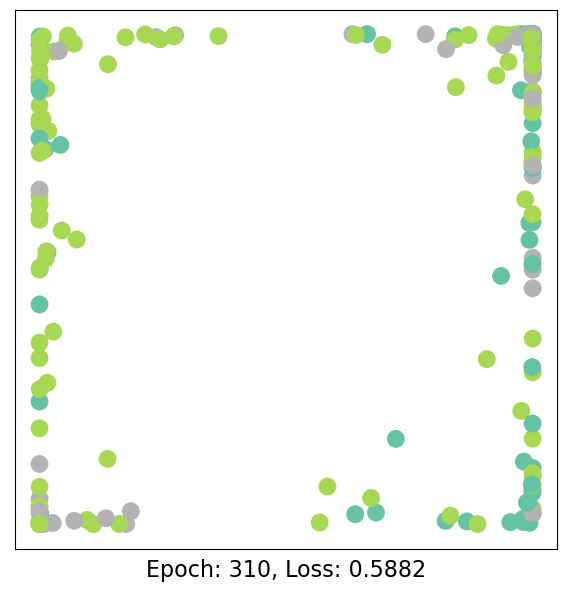

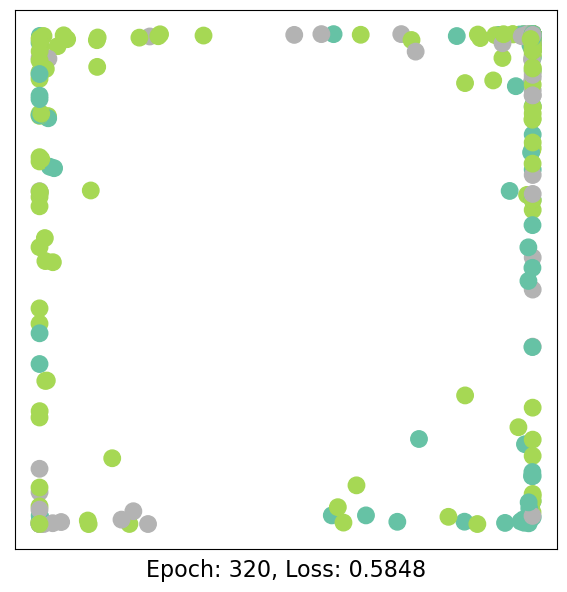

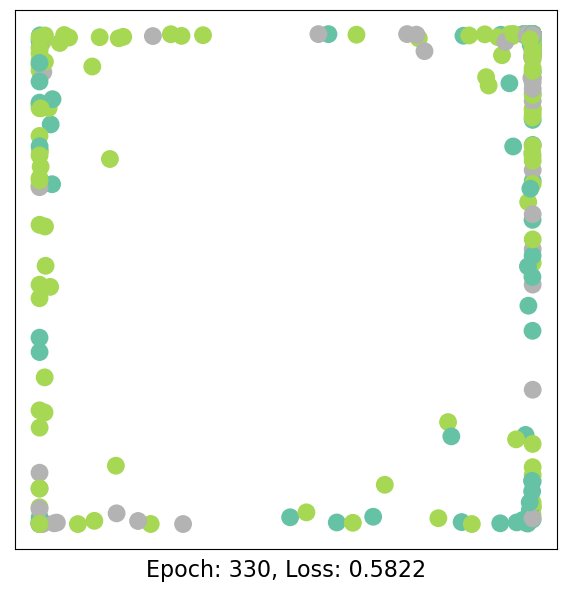

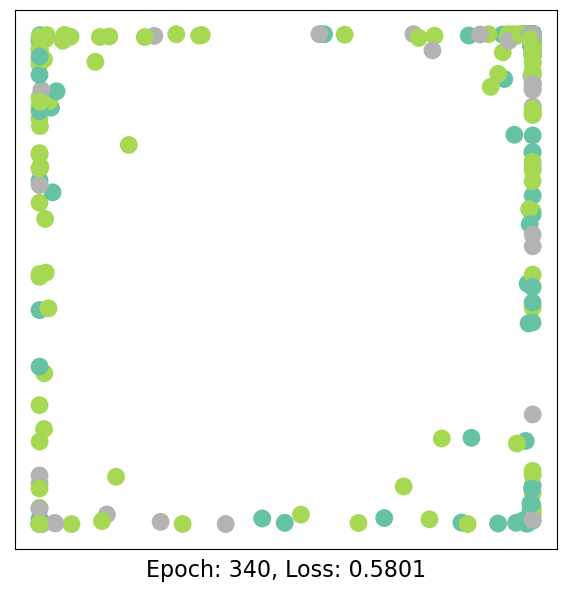

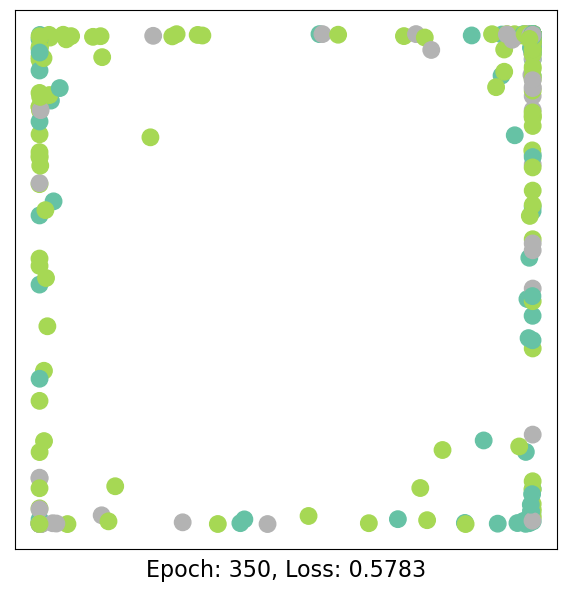

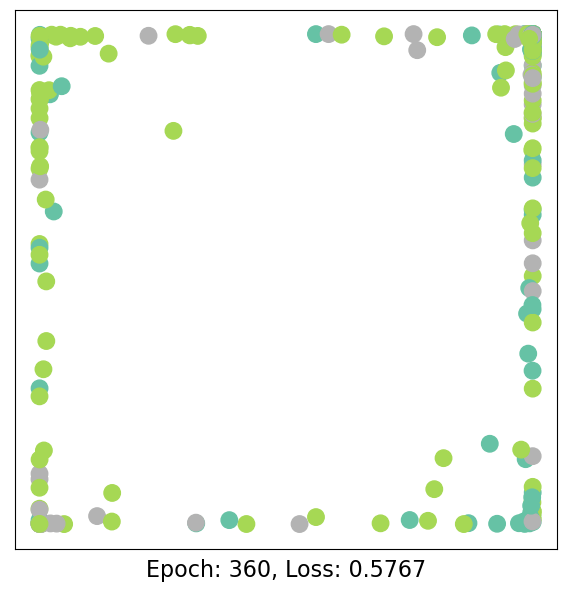

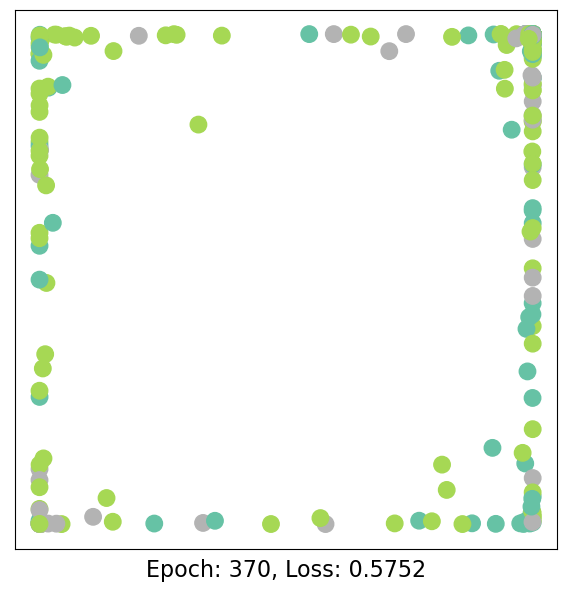

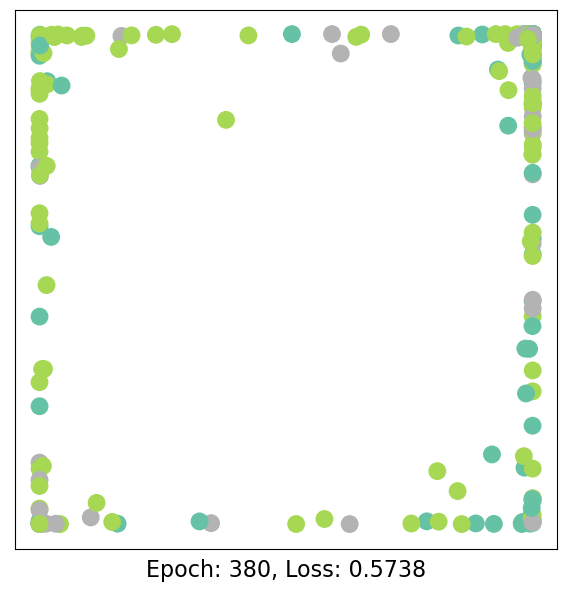

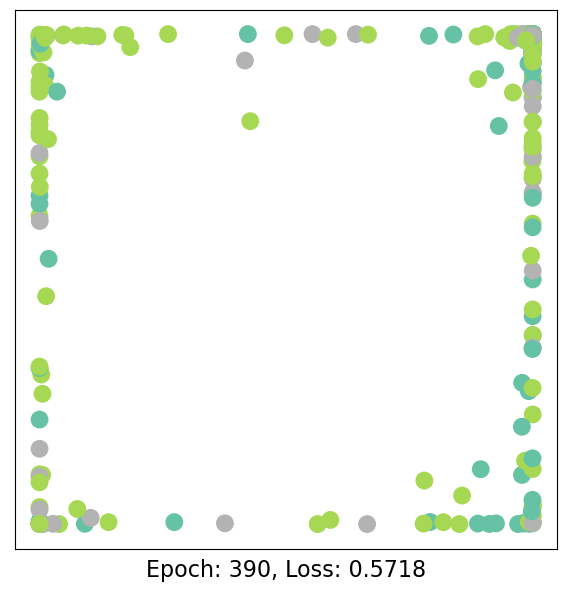

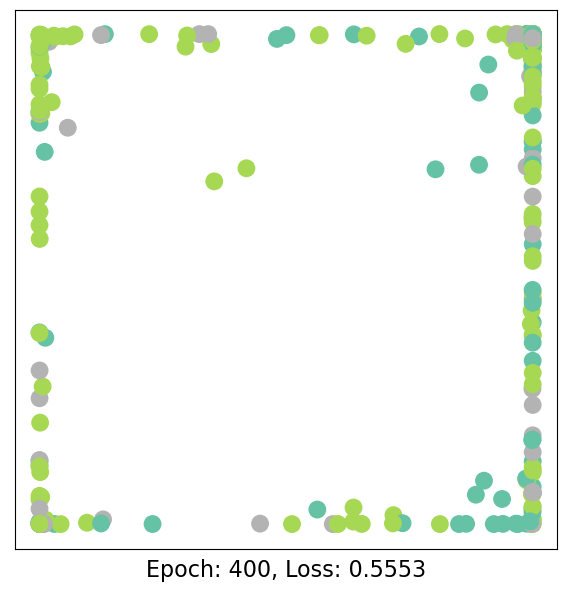

In [118]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

 # Tutorial 3
 Provo ora codice numero 3 colab (graph classification)

In [ ]:
# Devo trasformare per prima cosa tutti i documenti in grafi!


In [133]:
datasetGrafi = []
for Doc in tqdm(corpus_filtrato_embedding):
    Doc = np.array(Doc)
    A = np.zeros(shape = [len(Doc),len(Doc)], dtype = int)
    for i in range(len(Doc)):
        if (i == 0): # devo fare il caso k ==0 altrimenti k-1 = -1 mi dà l'elemento in fondo alla lista!
            A[i][1] = 1
        elif (i == len(Doc)-1):
            A[i][len(Doc)-2] = 1
        else:
            A[i][i-1] = 1
            A[i][i+1] = 1 

    #Atilde = A                       ## inutile per pytorch geometric!
    #for i in range(len(A)):
     #   Atilde[i][i]=1

    adj_list = []
    for i in range(len(A)):
        for j in range(len(A)):
            if (A[i][j]==1 and j!=i):
                temp_list = [i,j]
                adj_list.append(temp_list)

    edge_index = torch.tensor(adj_list, dtype=torch.long)
    x = torch.tensor(Doc0, dtype=torch.float)
    numero_casuale = random.choice([0, 1])
    y = torch.tensor(numero_casuale)

    data = Data(x=x, edge_index=edge_index.t().contiguous(), y = y)
    datasetGrafi.append(data)
    

 27%|████████████████████▉                                                        | 2778/10213 [05:06<13:39,  9.08it/s]


KeyboardInterrupt: 

In [134]:
datasetGrafi = []

for Doc in tqdm(corpus_filtrato_embedding):
    Doc = np.array(Doc)
    A = np.eye(len(Doc), dtype=int)  # Creazione della matrice di adiacenza con diagonale piena di 1
    A[:-1, 1:] += np.eye(len(Doc) - 1, dtype=int)  # Assegnazione dei 1 agli elementi sopra la diagonale
    A[1:, :-1] += np.eye(len(Doc) - 1, dtype=int)  # Assegnazione dei 1 agli elementi sotto la diagonale

    edge_index = torch.tensor(np.column_stack(np.where(A == 1)), dtype=torch.long)
    x = torch.tensor(Doc, dtype=torch.float)
    y = torch.tensor(random.choice([0, 1]))

    data = Data(x=x, edge_index=edge_index.t().contiguous(), y=y)
    datasetGrafi.append(data)

100%|███████████████████████████████████████████████████████████████████████████| 10213/10213 [01:37<00:00, 104.87it/s]


Osservo che questo codice è molto più efficiente del mio (ci sono voluti minuti invece che ore)!
La causa è la creazione della lista di adiacenza in maniera "intuitiva" fatta da me, il codice 
"**np.column_stack(np.where(A == 1))**" rende il tutto circa 30 volte più efficiente, non essendoci bisogno di fare due cicli for annidati!

In [165]:
torch.manual_seed(12345)

train_dataset = datasetGrafi[:6500]
test_dataset = datasetGrafi[6500:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 6500
Number of test graphs: 3713


In [167]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 256
DataBatch(x=[171932, 10], edge_index=[2, 515284], y=[256], batch=[171932], ptr=[257])

Step 2:
Number of graphs in the current batch: 256
DataBatch(x=[176517, 10], edge_index=[2, 529039], y=[256], batch=[176517], ptr=[257])

Step 3:
Number of graphs in the current batch: 256
DataBatch(x=[172458, 10], edge_index=[2, 516862], y=[256], batch=[172458], ptr=[257])

Step 4:
Number of graphs in the current batch: 256
DataBatch(x=[165410, 10], edge_index=[2, 495718], y=[256], batch=[165410], ptr=[257])

Step 5:
Number of graphs in the current batch: 256
DataBatch(x=[165559, 10], edge_index=[2, 496165], y=[256], batch=[165559], ptr=[257])

Step 6:
Number of graphs in the current batch: 256
DataBatch(x=[177826, 10], edge_index=[2, 532966], y=[256], batch=[177826], ptr=[257])

Step 7:
Number of graphs in the current batch: 256
DataBatch(x=[176168, 10], edge_index=[2, 527992], y=[256], batch=[176168], ptr=[257])

Step 8:
Number of graphs in the cu

In [169]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(10, hidden_channels) # numero di features per nodo
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels) 
        self.lin = Linear(hidden_channels, 2) # numero di classi

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(10, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [170]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Acc: 0.4903, Test Acc: 0.4969
Epoch: 002, Train Acc: 0.5095, Test Acc: 0.5031
Epoch: 003, Train Acc: 0.5095, Test Acc: 0.5031
Epoch: 004, Train Acc: 0.5095, Test Acc: 0.5031
Epoch: 005, Train Acc: 0.5095, Test Acc: 0.5031
Epoch: 006, Train Acc: 0.5095, Test Acc: 0.5031
Epoch: 007, Train Acc: 0.4905, Test Acc: 0.4969
Epoch: 008, Train Acc: 0.5095, Test Acc: 0.5031
Epoch: 009, Train Acc: 0.5095, Test Acc: 0.5031
Epoch: 010, Train Acc: 0.5055, Test Acc: 0.4904
Epoch: 011, Train Acc: 0.5117, Test Acc: 0.5026
Epoch: 012, Train Acc: 0.5157, Test Acc: 0.5012
Epoch: 013, Train Acc: 0.5160, Test Acc: 0.5023
Epoch: 014, Train Acc: 0.5098, Test Acc: 0.5031
Epoch: 015, Train Acc: 0.4998, Test Acc: 0.5012
Epoch: 016, Train Acc: 0.5168, Test Acc: 0.5009
Epoch: 017, Train Acc: 0.5223, Test Acc: 0.4947
Epoch: 018, Train Acc: 0.5235, Test Acc: 0.5001
Epoch: 019, Train Acc: 0.5246, Test Acc: 0.5007
Epoch: 020, Train Acc: 0.5198, Test Acc: 0.5071
Epoch: 021, Train Acc: 0.5254, Test Acc:

KeyboardInterrupt: 

Dopo un'ora di run ha fatto 33 epoch su 171, quindi sicuramente il train sarà lento, ora però non ci serve, visto che le labels sono date casualmente. Era solo per vedere se tutto funzionava!